In [69]:
import os
import imp
import numpy as np
import theano
import lasagne
import loading
from training import *
from network import *
from architectures import *

L = lasagne.layers
nl = lasagne.nonlinearities
T = theano.tensor

headdir = os.path.expanduser('~/Google Drive/Bas Zahy Gianni - Games')
paramsdir = os.path.join(headdir, 'Analysis/0_hvh/Params/nnets/temp')
datafile = os.path.join(headdir, 'Data/0_hvh/Clean/_summaries/model_input_with_groups.csv')
resultsdir = os.path.join(headdir, 'Analysis/0_hvh/Loglik/nnets')
data = loading.default_loader(datafile)

## Basic Prototyping

In [2]:
# CHANGES SINCE PREVIOUS BEST:
# - implementation. Now with better abstraction! 
#     Should have no effect on performance, but dev much easier.
# - training algo. Now using Adam instead of SBGD with Nesterov momentum 
#     mostly just faster convergence...)
# - changed activation on conv2d layer to be a pRelu with all units fitted (previously vanilla Relu)
# - changed activation on output to be leaky Relu with alpha=.3
# - changed initialization on output and conv2d layers to be He with proper func instead of Glorot
# - added a "feature pool" layer after conv2d. 
#     This was most impactful; improved performance by ~.05 and reduced overfitting

In [3]:
prototype = default_convnet
net = Network(default_convnet)

In [4]:
trainer = DefaultTrainer(stopthresh=100) # default: 125
net_list = trainer.train_all(architecture=default_convnet, data=data, seed=985227)

Epoch 0 took 1.547s
	training loss:			2.9994
	validation loss:		2.8461
	validation accuracy:		15.53%
	total time elapsed:		1.569s


/Users/gianni/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Epoch 50 took 1.589s
	training loss:			2.1766
	validation loss:		2.1221
	validation accuracy:		34.86%
	total time elapsed:		78.623s
Epoch 100 took 1.586s
	training loss:			2.0851
	validation loss:		2.0693
	validation accuracy:		36.33%
	total time elapsed:		151.896s
Epoch 150 took 1.377s
	training loss:			2.0626
	validation loss:		2.0521
	validation accuracy:		37.11%
	total time elapsed:		223.787s
Epoch 200 took 1.427s
	training loss:			2.0516
	validation loss:		2.0408
	validation accuracy:		37.60%
	total time elapsed:		292.880s
Epoch 250 took 1.332s
	training loss:			2.0411
	validation loss:		2.0461
	validation accuracy:		37.21%
	total time elapsed:		362.263s
Epoch 300 took 1.359s
	training loss:			2.0343
	validation loss:		2.0318
	validation accuracy:		37.60%
	total time elapsed:		431.081s
Epoch 350 took 1.393s
	training loss:			2.0131
	validation loss:		2.0311
	validation accuracy:		37.70%
	total time elapsed:		499.718s
Epoch 400 took 1.359s
	training loss:			1.9953
	validation loss:

In [7]:
for i, n in enumerate(net_list):
    n.save_params(os.path.join(paramsdir, '{} split agg fit'.format(i)))

## Subject finetuning prototyping

TODO:

try saving parameters from above and doing a reload/partial freeze

In [70]:
# TODO: save traces
# TODO: keep traces from one net to another?? or save separately and append...

# set fixed params with easy-access dicts, because we don't hate ourselves
trainer_settings = {
    'stopthresh':25,
    'update_args':{'learning_rate':.00001}
}

trainer_args = {
    'architecture':prototype,
    'seed':985227,
}

results = []
for i, net in enumerate(net_list):
    result = []
    PARAMS = L.get_all_param_values(net.net)
    for subno in range(40):
        subject_Xs = data[2]
        subject_ys = data[3]
        subject_Ss = data[4]
        S0 = [np.where(s==subno)[0] for s in subject_Ss]
        X0 = [subject_Xs[i][s] for i, s in enumerate(S0)]
        y0 = [subject_ys[i][s] for i, s in enumerate(S0)]
        sub_data = (data[0], data[1], X0, y0, S0)
        print('\nSUBJECT {}, NMOVES {} per split\n'.format(subno, len(S0[0])))

        batchsize=len(S0[0])//2
        sub_trainer = FineTuner(batchsize=batchsize, **trainer_settings)
        sub_net = sub_trainer.train_all(data=sub_data, startparams=PARAMS, **trainer_args)
        result.append(sub_net.test_err)
        sub_net.save_params(os.path.join(paramsdir, '{} split {} sub tune fit'.format(i, subno)))
        # add trace saving here
        
        
    results.append(result)

res = np.array(results).T
np.savetxt(os.path.join(resultsdir, 'nlls.txt'), res, fmt='%.18f', delimiter=',')

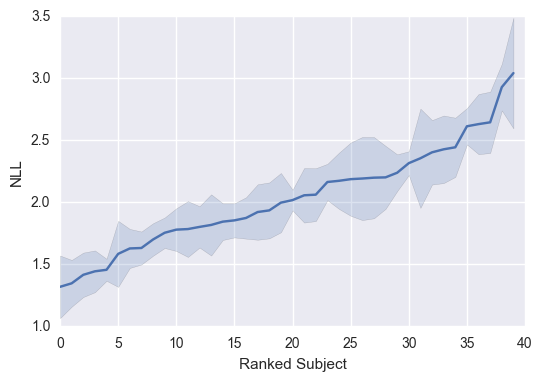

In [65]:
mos = [bmvs(res[i, :]) for i in range(res.shape[0])]
means = np.array([m[0][0] for m in mos])
lbs = np.array([m[0][1][0] for m in mos])
ubs = np.array([m[0][1][1] for m in mos])
idx = np.argsort(means)
plt.fill_between(x=np.arange(40), y1=lbs[idx], y2=ubs[idx], alpha=.2)
plt.plot(means[idx])
plt.setp(plt.gca(), xlabel='Ranked Subject', ylabel='NLL')
sns.despine()

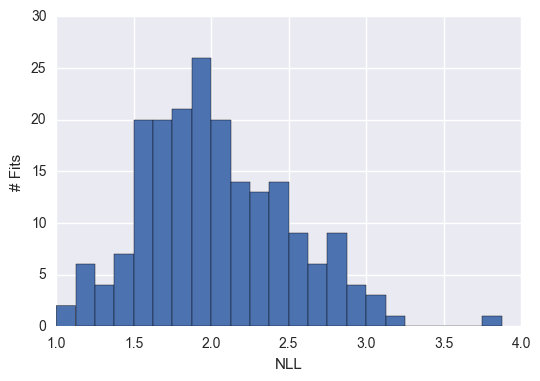

In [66]:
plt.hist(res.flatten(), bins = np.arange(1, 4, 1/8))
plt.setp(plt.gca(), xlabel='NLL', ylabel='# Fits')
sns.despine()

In [71]:
bmvs(np.array(res).flatten())

(Mean(statistic=2.0297389663420167, minmax=(1.9754359377545521, 2.0840419949294815)),
 Variance(statistic=0.21815111779251639, minmax=(0.18451519497299468, 0.25678486268659811)),
 Std_dev(statistic=0.46647415702644379, minmax=(0.42955231924993104, 0.506739442600039)))

## Autoencoder prototyping

In [ ]:
def autoencoder_prototype(input_var=None):
    input_shape = (None, 2, 4, 9)
    inpuL.InputLayer = L.InputLayer(shape=input_shape, input_var=input_var)
    network = L.COnv2DLayer(
        input_layer, num_filters=32, filter_size=(4, 4), pad='full',
        nonlinearity=nl.identity
    )
    L.ParametricRectifierLayerrLayeshared_axes=Rectifier(network, shL.FeaturePoolLayerl')
    network = L.FeaturePoolLayer(network, pool_functioL.DropoutLayerm, pool_size=2)
    network = L.DropoutLayer(network, p=.75)
    network = L.DenseLayer(
        network, num_units=72,
        nonlinearity=nl.very_leaky_rectify, W=lasagne.init.HeUniform(gain='relu')
    )
    network = L.ReshapeLayer(
        network, shape=(-1, 2, 4, 9)
    )
    return network

In [ ]:
class Autoencoder(Network):
    """
    Overwrites loss functions for training an autoencoder instead
    of softmax output classifier
    """
    def objectives(self):
        """Must define: loss, test_loss, test_acc"""
        self.loss = lasagne.objectives.squared_error(self.prediction, self.target_var)
        self.loss = self.loss.mean()
        self.test_loss = lasagne.objectives.squared_error(self.test_prediction, self.target_var)
        self.test_loss = self.test_loss.mean()
        self.test_acc = T.mean(T.abs(self.test_prediction - self.target_var))
        return None

# class AutoTrainer(DefaultTrainer):
#     """
#     Overwrites training functions for training an autoencoder instead
#     of softmax output classifier
#     """
#     pass

# Can actually pass data to existing trainer by replacing ys with a copy of Xs!

class LadderNet(Network):
    """
    Loads conv layer params from autoencoder save and sets them on current classifier
    Needs overwrite of self.build() that loads conv2d params, then sets them untrainable.
    """
    def __init__(self, architecture, paramsfile):
        self.paramsfile = paramsfile
        super(LadderNet, self).__init__(architecture)
    
    def build(self):
        super(LadderNet, self).build()
        
        # Finish this soon!
        return None
    
    def load_conv_params(self):
        with np.load(paramsfile) as loaded:
#             L.

In [ ]:
from scipy.stats import bayes_mvs as bmvs
bmvs([n.test_err for n in net_list], alpha=.95)

In [ ]:


D, groups, Xs, ys, Ss = loading.default_loader(datafile)

splitsize = len(Xs)
r = np.arange(splitsize)
r = np.tile(r, [splitsize, 1])
r = r + r.T
split_indices = r % splitsize

split = 0
train_i = split_indices[split, :3]
val_i = split_indices[split, 3:4]
test_i = split_indices[split, 4:]

X, y, S = [np.concatenate(np.array(Zs)[train_i]) for Zs in [Xs, ys, Ss]]
Xv, yv, Sv = [np.concatenate(np.array(Zs)[val_i]) for Zs in [Xs, ys, Ss]]
Xt, yt, St = [np.concatenate(np.array(Zs)[test_i]) for Zs in [Xs, ys, Ss]]
X, y = loading.augment((X, y))
S = np.concatenate([S, S, S, S])

In [ ]:
np.random.seed(985227)

net = Network(default_convnet)
trainer = Trainer()

trainer.train(net, training_data=(X, y), validation_data=(Xv, yv))
err, acc, bats = trainer.test(net, (Xt, yt))